In [ ]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb


Loading The Dataset

In [189]:
file_path = 'CrossCheck_Daily_Data.xlsx'  
data = pd.read_excel(file_path)

print("Dataset Shape:", data.shape)
print("Column Names:", data.columns)
print(data.head())

Dataset Shape: (23573, 155)
Column Names: Index(['study_id', 'eureka_id', 'day', 'act_in_vehicle_ep_0',
       'act_in_vehicle_ep_1', 'act_in_vehicle_ep_2', 'act_in_vehicle_ep_3',
       'act_in_vehicle_ep_4', 'act_on_bike_ep_0', 'act_on_bike_ep_1',
       ...
       'unlock_duration_ep_0', 'unlock_duration_ep_1', 'unlock_duration_ep_2',
       'unlock_duration_ep_3', 'unlock_duration_ep_4', 'unlock_num_ep_0',
       'unlock_num_ep_1', 'unlock_num_ep_2', 'unlock_num_ep_3',
       'unlock_num_ep_4'],
      dtype='object', length=155)
   study_id eureka_id       day  act_in_vehicle_ep_0  act_in_vehicle_ep_1  \
0        -1      u004  20150122                    0                    0   
1        -1      u004  20150123                    0                    0   
2        -1      u004  20150124                    0                    0   
3        -1      u004  20150125                    0                    0   
4        -1      u004  20150126                    0                    0   

Data Aggregation

In [190]:
#Aggregate the eps to make it one full day
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

new_columns = []
processed_base_columns = set()  
columns_to_drop = []  


epochs = ['ep_0', 'ep_1', 'ep_2', 'ep_3']  #only taking the first four eps as they indicates the whole day


for col in numerical_cols:
    if any(epoch in col for epoch in epochs):  # to see if the coulmn has ep_ in it 
        
        #removing ep for the bas coulmn name
        epoch_num = [epoch for epoch in epochs if epoch in col][0]
        base_col_name = col.replace(f'_{epoch_num}', '') 

        # Check if the coulmn has been aggregated before and not aggregate ep_4 
        if base_col_name not in processed_base_columns:
            columns_to_sum = [col for col in data.columns if base_col_name in col and 'ep_4' not in col]
            aggregated_col = data[columns_to_sum].sum(axis=1)
            new_columns.append(aggregated_col.rename(base_col_name + '_sum'))
            

            columns_to_drop.extend([col for col in columns_to_sum if 'ep_4' not in col]) 

            # Mark the base column as processed
            processed_base_columns.add(base_col_name)

# add the new coulmns to the data 
if new_columns:
    data = pd.concat([data] + new_columns, axis=1)

#drop the original coulmns 
data.drop(columns=columns_to_drop, inplace=True)

#data.to_csv("processed_data.csv", index=False)


In [191]:


# Identify rows with recorded EMA scores
data['is_target'] = data['ema_score'].notna()

# Find the indices where EMA scores are available
ema_indices = data[data['is_target']].index.tolist()

# List to store new dataset rows
new_data = []

# Extract feature columns (excluding 'ema_score', 'study_id', 'eureka_id', and 'day')
feature_cols = [col for col in data.columns if col not in ['ema_score', 'study_id', 'eureka_id', 'day', 'is_target']]

# Iterate over each EMA segment
for i in range(len(ema_indices) - 1):
    start_idx = ema_indices[i]  # Start from last recorded EMA
    end_idx = ema_indices[i + 1]  # Stop at next recorded EMA

    # Get segment data
    segment = data.iloc[start_idx:end_idx]

    # Compute average of feature columns
    avg_features = segment[feature_cols].mean().to_dict()

    # Assign the next recorded EMA score as the target
    avg_features['ema_score'] = data.loc[end_idx, 'ema_score']

    # Store metadata
    avg_features['study_id'] = data.loc[start_idx, 'study_id']  # Keep the participant ID
    avg_features['start_day'] = data.loc[start_idx, 'day']  # First day in the segment
    avg_features['end_day'] = data.loc[end_idx, 'day']  # Last day in the segment

    # Store the result
    new_data.append(avg_features)

# Convert new dataset to DataFrame
data = pd.DataFrame(new_data)



Data Cleaning

In [192]:
# Remove columns that have only one unique value
data = data.loc[:, data.nunique() > 1]

# Save the cleaned dataset
#data.to_csv("processed_ema_dataset.csv", index=False)

#print(f"✅ Cleaned dataset saved with {data.shape[1]} features")
print(data.head())

   act_in_vehicle_ep_4  act_on_bike_ep_4  act_on_foot_ep_4  act_still_ep_4  \
0             0.000000          0.000000          0.000000    21600.000000   
1          1434.500000         52.000000        211.000000    19785.000000   
2           701.142857          3.000000        296.142857    19977.142857   
3           957.666667         10.333333         57.000000    20424.666667   
4           594.500000         52.500000       1321.500000    18899.500000   

   act_tilting_ep_4  act_unknown_ep_4  audio_amp_mean_ep_4  \
0          0.000000          0.000000           371.575458   
1         46.500000         71.000000          2924.937914   
2        162.142857        460.428571          1687.404919   
3         99.666667         50.666667          1907.264467   
4        239.000000        493.000000          2144.723871   

   audio_amp_std_ep_4  audio_convo_duration_ep_4  audio_convo_num_ep_4  ...  \
0           44.864366                   0.000000              0.000000  ...   


In [193]:
data.fillna(data.mean(), inplace=True)

print(data)

      act_in_vehicle_ep_4  act_on_bike_ep_4  act_on_foot_ep_4  act_still_ep_4  \
0                0.000000          0.000000          0.000000    21600.000000   
1             1434.500000         52.000000        211.000000    19785.000000   
2              701.142857          3.000000        296.142857    19977.142857   
3              957.666667         10.333333         57.000000    20424.666667   
4              594.500000         52.500000       1321.500000    18899.500000   
...                   ...               ...               ...             ...   
6358          3510.000000         36.666667        798.666667    14936.333333   
6359          2012.500000         16.500000       1061.000000    16086.500000   
6360          8275.000000         63.500000       1354.500000     7828.000000   
6361          7850.666667         35.333333        752.000000     9019.333333   
6362          8955.000000         24.000000        426.500000     7956.000000   

      act_tilting_ep_4  act

In [194]:
data['ema_score_lag_1'] = data['ema_score'].shift(1)
data['ema_score_lag_7'] = data['ema_score'].shift(7)
data['start_day'] = pd.to_datetime(data['start_day'])
data['end_day'] = pd.to_datetime(data['end_day'])

# Feature engineering from time
data['day_diff'] = (data['end_day'] - data['start_day']).dt.days
data['day_of_week'] = data['start_day'].dt.dayofweek
data['month'] = data['start_day'].dt.month
data['day'] = data['start_day'].dt.day
data['weekofyear'] = data['start_day'].dt.isocalendar().week
data = data.dropna()


In [195]:
features = data.drop(['ema_score', 'study_id', 'start_day', 'end_day'], axis=1)
target = data['ema_score']

# ============================
# 3. Time-based train/test split
# ============================
train_size = int(len(data) * 0.8)
X_train = features.iloc[:train_size]
X_test = features.iloc[train_size:]
y_train = target.iloc[:train_size]
y_test = target.iloc[train_size:]

# ======================
# 4. Scale the features
# ======================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [196]:
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [197]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [198]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 57.0739 - mae: 6.0078 - val_loss: 12.8927 - val_mae: 2.7423
Epoch 2/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.6854 - mae: 2.6262 - val_loss: 9.0881 - val_mae: 2.1980
Epoch 3/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8714 - mae: 2.2625 - val_loss: 8.4356 - val_mae: 2.1141
Epoch 4/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3161 - mae: 2.1934 - val_loss: 8.1325 - val_mae: 2.0559
Epoch 5/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9596 - mae: 2.1132 - val_loss: 7.7246 - val_mae: 2.0538
Epoch 6/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7923 - mae: 2.0108 - val_loss: 7.4674 - val_mae: 2.0168
Epoch 7/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4957 - mae: 2.0504 - val_loss: 7.2710 - val_mae: 1.9093
Epoch 8/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.7903 - mae: 1.9410 - val_loss: 7.1464 - val_mae: 1.8644
Epoch 9/50
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

In [ ]:

loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
mse = mean_squared_error(y_test, model.predict(X_test_scaled))
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"✅ Test MAE: {mae:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MSE: 14.8720
✅ Test MAE: 2.6532


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


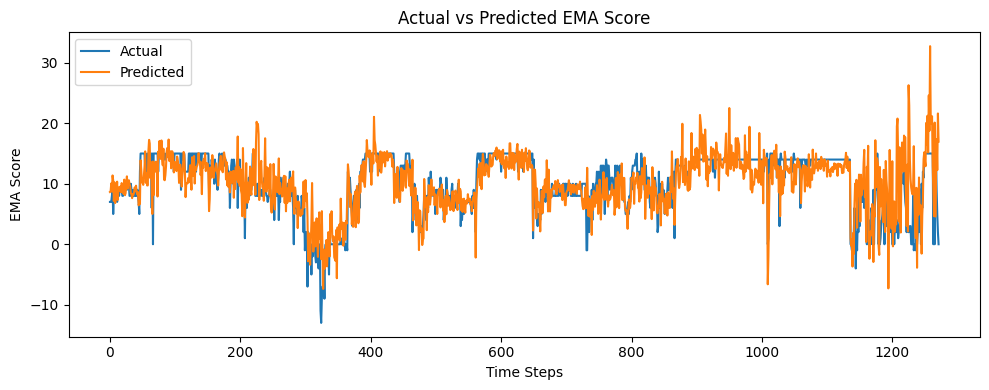

In [200]:
y_pred = model.predict(X_test_scaled).flatten()

plt.figure(figsize=(10, 4))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted EMA Score')
plt.xlabel('Time Steps')
plt.ylabel('EMA Score')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def build_model(hp):
    model = Sequential()
    
    # Tuning the number of layers and the number of units in each LSTM layer
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='relu', input_shape=(X_train_tf.shape[1], 1),
                   return_sequences=True))
    
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='relu'))
    
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(1))
    
    # Tuning the learning rate for the optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)),
                  loss='mean_squared_error', metrics=['mae'])
    
    return model

Train Model

In [201]:
# Features (X) and Target (y)
X = data.drop(['ema_score', 'study_id', 'start_day', 'end_day'], axis=1)  # Drop non-relevant columns
y = data['ema_score']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Data split complete: {X_train.shape[0]} training rows, {X_test.shape[0]} test rows")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to TensorFlow format
X_train_tf = tf.convert_to_tensor(X_train_scaled, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test_scaled, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Check shape
print(f"Train shape: {X_train_tf.shape}, Test shape: {X_test_tf.shape}")

✅ Data split complete: 5084 training rows, 1272 test rows
Train shape: (5084, 76), Test shape: (1272, 76)


In [202]:
# Initialize and train the SVR model
svm_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)  # Default hyperparameters
svm_model.fit(X_train, y_train)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,    # Number of trees (can increase for better performance)
    max_depth=None,      # Let the model decide optimal depth
    random_state=42,     # Ensures reproducibility
    n_jobs=-1            # Utilizes all CPU cores for faster training
)

# Initialize the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,     # Number of trees
    learning_rate=0.1,    # Learning rate (controls step size)
    max_depth=6,          # Tree depth to control overfitting
    random_state=42
)

# Initialize the LightGBM model
lgbm_model = LGBMRegressor(
    n_estimators=200,  # Number of trees
    learning_rate=0.1,  # Step size
    max_depth=6,  # Limits tree depth to prevent overfitting
    random_state=42
)

# Define the neural network model
NNL = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),  # Hidden layer 1
    keras.layers.Dense(32, activation='relu'),  # Hidden layer 2
    keras.layers.Dense(1)  # Output layer (regression)
])


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


SVM

In [203]:
# Predictions
y_pred = svm_model.predict(X_test)
# Custom Regression Accuracy Function
def regression_accuracy(y_true, y_pred):
    return 100 * (1 - (mean_absolute_error(y_true, y_pred) / y_true.mean()))

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = regression_accuracy(y_test, y_pred)

print(f"✅ SVM Model Performance:")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 R²: {r2:.2f}")
print(f"🎯 Accuracy: {accuracy:.2f}%")

✅ SVM Model Performance:
📉 MSE: 34.23
📈 R²: -0.00
🎯 Accuracy: 37.35%


Random Forset

In [204]:
# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

accuracy = max(0, 1 - (mse / np.var(y_test)))

print(f"✅ Random Forest Model Performance:")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 R²: {r2:.2f}")
print(f"🎯 Accuracy: {accuracy:.2%}")

✅ Random Forest Model Performance:
📉 MSE: 7.82
📈 R²: 0.77
🎯 Accuracy: 77.14%


HyperParmter Tuning

XGBoost

In [205]:
# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = max(0, 1 - (mse / np.var(y_test)))  # Regression accuracy approximation

print(f"✅ XGBoost Model Performance:")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 R²: {r2:.2f}")
print(f"🎯 Accuracy: {accuracy:.2%}")

✅ XGBoost Model Performance:
📉 MSE: 8.30
📈 R²: 0.76
🎯 Accuracy: 75.71%


LightGBM

In [206]:
lgbm_model.fit(X_train, y_train)

# Predictions
y_pred = lgbm_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = max(0, 1 - (mse / np.var(y_test)))  # Regression accuracy approximation

print(f"✅ LightGBM Model Performance:")
print(f"📉 MSE: {mse:.2f}")
print(f"📈 R²: {r2:.2f}")
print(f"🎯 Accuracy: {accuracy:.2%}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12620
[LightGBM] [Info] Number of data points in the train set: 5084, number of used features: 70
[LightGBM] [Info] Start training from score 7.644965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

MLP

In [207]:
# Compile the model
NNL.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = NNL.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

# Evaluate the model
loss, mae = NNL.evaluate(X_test_scaled, y_test)
print(f"✅ Neural Network Performance:")
print(f"📉 Loss (MSE): {loss:.2f}")
print(f"📈 MAE: {mae:.2f}")
print(f"📊 R-squared: {r2:.2f}")

Epoch 1/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 34.4101 - mae: 4.3981 - val_loss: 9.9973 - val_mae: 2.2664
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8078 - mae: 2.2220 - val_loss: 9.1978 - val_mae: 2.1905
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.7027 - mae: 2.0680 - val_loss: 9.0512 - val_mae: 2.1028
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4506 - mae: 2.0548 - val_loss: 8.5340 - val_mae: 2.1194
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8393 - mae: 1.9593 - val_loss: 8.6505 - val_mae: 2.1005
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7017 - mae: 1.9512 - val_loss: 8.9307 - val_mae: 2.2234
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1376 - mae: 1.8843 - val_loss: 8.6401 - val_mae: 2.0907
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2275 - mae: 1.8836 - val_loss: 8.8427 - val_mae: 2.1458
Epoch 9/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms